# Sentiment Analysis - Wildfires

## Install Libraries

In [3]:
import pandas as pd
import numpy as np
import datetime
import tweepy
import re
import nltk
import spacy

from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

from cleantext import clean

import wordcloud
import matplotlib.pyplot as plt

import sklearn
from sklearn.feature_extraction.text import CountVectorizer

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


# API

In [4]:
# Authentication
api_key = "Please insert your key"
api_key_secret = "Please insert your key"
access_key = "Please insert your key"
access_key_secret = "Please insert your key"

auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_key, access_key_secret)

api = tweepy.API(auth, wait_on_rate_limit = True)

# Gathering the Data

In [5]:
tweets = tweepy.Cursor(api.search_tweets, q = "wildfire -filter:retweets", lang = "en").items(15000)

In [4]:
%%time
tweet_list = []
tweet_date = []
tweet_rt = []
tweet_fav = []

for tweet in tweets:
    tweet_list.append(tweet.text)
    tweet_date.append(tweet.created_at)
    tweet_rt.append(tweet.retweet_count)
    tweet_fav.append(tweet.favorite_count)
    
wildfire = pd.DataFrame({"tweets": tweet_list, "date": tweet_date, "rt": tweet_rt, "fav": tweet_fav})

Unauthorized: 401 Unauthorized
89 - Invalid or expired token.

In [ ]:
wildfire.to_csv("wildfire.csv")

NameError: name 'wildfire' is not defined

# Data

In [6]:
wildfire = pd.read_csv("wildfire.csv")
wildfire.reset_index(drop=True, inplace=True)
wildfire

,Unnamed: 0,tweets,date,rt,fav
0,0,Blue Mountains Wildfire January 1994 https://t...,14/08/2022 14:12,0,0
1,1,*Flashback*\n\nAugust 2017... wildfire Smoke b...,14/08/2022 14:10,0,0
2,2,@Ebuka243 just like a wildfire🦍,14/08/2022 14:10,0,0
3,3,Europe's blistering summer may not be over yet...,14/08/2022 14:10,0,0
4,4,Pretty serious #wildfire at Newgale right now ...,14/08/2022 14:09,1,1
...,...,...,...,...,...
14995,14995,@Joe71545644 They are able to go out immediate...,07/08/2022 08:33,0,0
14996,14996,devastating in particular for the Karuk and Yu...,07/08/2022 08:32,2,1
14997,14997,Now playing on WGMU: 1999 WILDFIRE (CLEAN) by ...,07/08/2022 08:28,0,0
14998,14998,Want your life reduced to this bag due to wild...,07/08/2022 08:12,6,6


In [7]:
wildfire.drop(wildfire.columns[[0]], axis=1, inplace=True)
wildfire

,tweets,date,rt,fav
0,Blue Mountains Wildfire January 1994 https://t...,14/08/2022 14:12,0,0
1,*Flashback*\n\nAugust 2017... wildfire Smoke b...,14/08/2022 14:10,0,0
2,@Ebuka243 just like a wildfire🦍,14/08/2022 14:10,0,0
3,Europe's blistering summer may not be over yet...,14/08/2022 14:10,0,0
4,Pretty serious #wildfire at Newgale right now ...,14/08/2022 14:09,1,1
...,...,...,...,...
14995,@Joe71545644 They are able to go out immediate...,07/08/2022 08:33,0,0
14996,devastating in particular for the Karuk and Yu...,07/08/2022 08:32,2,1
14997,Now playing on WGMU: 1999 WILDFIRE (CLEAN) by ...,07/08/2022 08:28,0,0
14998,Want your life reduced to this bag due to wild...,07/08/2022 08:12,6,6


# Data Preprocessing

In [ ]:
def remove_text (tweet):
    tweet = re.sub('@[A-Za-z0-9-_]+', '', tweet) #to remove mentions
    tweet = re.sub(r'#', '', tweet) # to remove hashtags
    tweet = re.sub(r'RT[/s]+', '', tweet) # to remove retweets
    return tweet

In [ ]:
def remove_links (tweet):
    tweet = re.sub(r'https?:\/\/\S+', '', tweet)# remove hyper links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # remove bitly links
    tweet = tweet.strip('[links]') # remove links
    return tweet

In [ ]:
mywords = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
mystopwords = set(stopwords.words('english'))
mycharacters = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•∑€®₺¥π¨`æ´¬¨∆^∂ßæ≈√∫~µ≤≥÷ƒ@'


In [ ]:
def remove_words (tweet):
     tweet = re.sub('['+mycharacters + ']+', ' ', tweet) # remove characters 
     tweet = re.sub('\s+', ' ', tweet)   #remove double spacing
     tweet = re.sub('([0-9]+)', '', tweet) # remove numbers
     return tweet

In [ ]:
def clean_tweets(tweet, bigrams=False):
    tweet = tweet.lower() # to make lower case
    tweet = remove_text(tweet)
    tweet = remove_links(tweet)
    tweet = remove_words(tweet)
    tweet = clean(tweet, no_emoji=True)
    tweet_token = [word for word in tweet.split(' ')
                            if word not in mystopwords] # remove stopwords

    tweet_token = [mywords(word) if '#' not in word else word
                        for word in tweet_token] # apply word rooter
    if bigrams:
        tweet_token = tweet_token+[tweet_token[i]+'_'+tweet_token[i+1]
                                            for i in range(len(tweet_token)-1)]
    tweet = ' '.join(tweet_token)
    tweet = re.sub('wildfir', 'wildfire', tweet) #to correct wildfire because of data cleaning
    return tweet

In [ ]:
wildfire['clean_tweets'] = wildfire.tweets.apply(clean_tweets)
wildfire

AttributeError: 'DataFrame' object has no attribute 'tweets'

# Word Cloud

In [ ]:
from wordcloud import WordCloud

In [ ]:
text = " ".join(i for i in wildfire["clean_tweets"])
text

'blue mountain wildfire januari flashback august wildfire smoke block sun midday hol portug like wildfire europ blister summer may yet alreadi break record nearli hectar r pretti seriou wildfire newgal right pembrokeshir wale wildfire stormhour thephotohour major wildfire spain forc evacu wildflow wildfire fire spread inland due onshor breez toward hous newgal newgalebeach jame still wear flower europ set record wildfire destruct beauti bottom larg wildfire experienc colorado across west threaten home risk "the overlap wildfire risk poverti concentr insur market get peopl think polici larg wildfire northeast spain grew rapidli overnight burn control sunday forc evacu larg wildfire northeast spain grew rapidli overnight burn control sunday forc evacu campfir close weekend pack soak water dirt stir stick macron plan hold talk france\' wildfire manag jenni che aug listen articl macron plan hold talk france\' wildfire manag jenni che aug listen articl case commerci log wildfire prone fores

In [ ]:
text = text.replace('amp','')
text = text.replace('ew', '')
text = text.replace('via', '')
text = text.replace('lis', '')
text = text.replace('peopl', 'people')
text = text.replace('peoplee', 'people')
text = text.replace('peopleee', 'people')
text = text.replace('peopleeee', 'people')
text = text.replace('peopleeeee', 'people')
text = text.replace('peopleeeeee', 'people')
text = text.replace('peopleeeeeee', 'people')
text = text.replace('franc', 'france')
text = text.replace('battl', 'battle')
text = text.replace('servic', 'service')
text = text.replace('wildfire near', 'near')
text = text.replace('wildfire burn', 'burn')
text = text.replace('wildfire risk', 'risk')
text = text.replace('wildfire smoke', 'smoke')
text = text.replace('wildfire season', 'season')
text = text.replace('battlee', 'battle')
text = text.replace('battlee monster', 'battle monster')
text = text.replace('francee', 'france')
text = text.replace('franceeeeeeeee', 'france')
text = text.replace('firefighterer', 'firefighter')
text = text.replace('monster wildfire', 'monster')
text = text.replace('firefighter battlee', 'firefighter battle')
text = text.replace('francee firefighter', 'firefighter')
text = text.replace('firefighterererer battlee', 'firefightererer battle')
text = text.replace('firefighterererererererererer', 'firefighter')
text = text.replace('firefighter battleeeeee', 'battle')
text = text.replace('firefighter battleeee', 'battle')
text = text.replace('firefighter battleee', 'battle')
text = text.replace('firefighter battlee', 'battle')

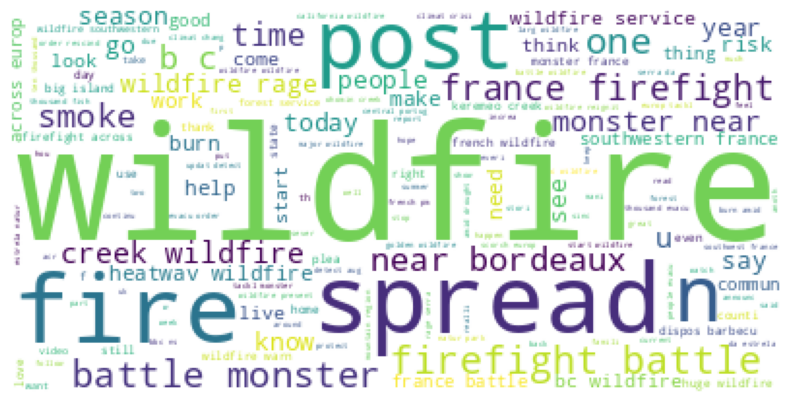

In [ ]:
wordcloud = WordCloud(max_font_size = 100,
                      background_color = "white").generate(text)

plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()                                                                                                                                                                                                        

# nGram

#### We wanted to see most frequent words group in order to understand the tweets more.

In [ ]:
def get_top_n_gram(corpus,ngram_range,n=None):
    vec = CountVectorizer(ngram_range=ngram_range,stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
#n2_bigram
n2_bigrams = get_top_n_gram(wildfire['clean_tweets'],(2,2),20)
n2_bigrams

[('like wildfire', 978),
 ('spread like', 669),
 ('monster wildfire', 625),
 ('ew post', 606),
 ('wildfire risk', 447),
 ('wildfire near', 443),
 ('battl monster', 381),
 ('firefight battl', 378),
 ('wildfire smoke', 342),
 ('wildfire burn', 313),
 ('creek wildfire', 304),
 ('near bordeaux', 271),
 ('wildfire rage', 244),
 ('franc firefight', 214),
 ('wildfire season', 212),
 ('wildfire franc', 188),
 ('heatwav wildfire', 168),
 ('wildfire servic', 157),
 ('bc wildfire', 156),
 ('southwestern franc', 146)]

In [ ]:
#n3_trigram
n3_trigrams = get_top_n_gram(wildfire['clean_tweets'],(3,3),20)
n3_trigrams

[('spread like wildfire', 617),
 ('battl monster wildfire', 364),
 ('monster wildfire near', 260),
 ('wildfire near bordeaux', 257),
 ('firefight battl monster', 236),
 ('franc firefight battl', 199),
 ('bc wildfire servic', 131),
 ('hawaii big island', 125),
 ('keremeo creek wildfire', 125),
 ('monster wildfire franc', 123),
 ('franc battl monster', 119),
 ('tackl monster wildfire', 109),
 ('wildfire southwestern franc', 109),
 ('firefight europ tackl', 90),
 ('europ tackl monster', 90),
 ('updat detect aug', 87),
 ('evacu order rescind', 83),
 ('french wildfire reignit', 82),
 ('serra da estrela', 82),
 ('estrela natur park', 80)]

In [ ]:
wildfire[wildfire.clean_tweets.str.find('spread like wildfire')!= -1].sort_values('fav', ascending = False)

,Unnamed: 0,tweets,date,rt,fav,clean_tweets
2263,2263,Disinformation claiming “Trump was going to se...,13/08/2022 02:29,45,729,"disinform claim ""trump go sell nuclear secret ..."
9422,9422,This video is spreading like wildfire on Ukrai...,10/08/2022 13:44,39,497,video spread like wildfire ukrainian social me...
2445,2445,"We’re all going to jail! \n\nThat, and other o...",12/08/2022 23:22,86,355,we'r go jail overreact spread like wildfire in...
2051,2051,Go audition now. Once in a lifetime opportunit...,13/08/2022 06:39,202,260,go audit lifetim opportun spread like wildfire
13956,13956,The rumour spreads like wildfire and some snar...,08/08/2022 01:37,0,241,rumour spread like wildfire snarki remark made...
...,...,...,...,...,...,...
7224,7224,That fuckin feminist is a scam video spreading...,11/08/2022 10:51,0,0,fuckin feminist scam video spread like wildfire
7085,7085,So are we not shutting the country down with m...,11/08/2022 11:50,0,0,shut countri monkeypox spread like wildfire
7043,7043,@Sebastijanpius @CawrCatti Turn off the Boss m...,11/08/2022 12:06,0,0,turn boss music need know new std spread like ...
6844,6844,That shit was spread like wildfire https://t.c...,11/08/2022 13:21,0,0,shit spread like wildfire


In [ ]:
#n4_trigram
n4_trigrams = get_top_n_gram(wildfire['clean_tweets'],(4,4),20)
n4_trigrams

[('monster wildfire near bordeaux', 244),
 ('battl monster wildfire near', 236),
 ('firefight battl monster wildfire', 229),
 ('franc firefight battl monster', 194),
 ('franc battl monster wildfire', 118),
 ('firefight europ tackl monster', 90),
 ('europ tackl monster wildfire', 90),
 ('tackl monster wildfire franc', 90),
 ('drought hawaii big island', 79),
 ('wildfire burn amid drought', 78),
 ('burn amid drought hawaii', 78),
 ('amid drought hawaii big', 78),
 ('serra da estrela natur', 76),
 ('da estrela natur park', 76),
 ('wildfire rage serra da', 75),
 ('rage serra da estrela', 74),
 ('estrela natur park mountain', 74),
 ('natur park mountain region', 74),
 ('park mountain region central', 74),
 ('mountain region central portug', 74)]

#### We can see the tweets which got mean value and the most favorites and retweets.

In [ ]:
mean_fav = round(wildfire['fav'].mean(),3)
mean_fav

6.453

In [ ]:
print ('top 10 favorite tweets:')
wildfire.sort_values('fav', ascending=False).head(10)

top 10 favorite tweets:


,Unnamed: 0,tweets,date,rt,fav,clean_tweets
2651,2651,Let me congratulate the workers at Trader Joe'...,12/08/2022 21:10,612,5204,et congratul worker trader joe minneapoli vote...
7589,7589,France has asked for help amid a wildfire-cris...,11/08/2022 08:05,222,1726,franc ask help amid wildfire crisi poland anno...
1498,1498,Spotted in the Malvern Hills. Everything is ti...,13/08/2022 14:45,577,1689,pot malvern hill everyth tinder dri miracl sta...
12368,12368,"Canada: This is Leslie Dart. She planted 4,545...",08/08/2022 20:33,281,1416,canada lesli dart plant tree one day burn scar...
1535,1535,Chapter 15 of Wildfire\n#タル鍾 #tartali \nEng t...,13/08/2022 14:20,298,1170,chapter wildfire tartali eng translat part lt ...
1258,1258,'Next summer we could be in real trouble' \n\n...,13/08/2022 16:51,351,1013,next summer could real troubl dr rob thompson ...
2706,2706,A dangerous and likely defamatory lie about th...,12/08/2022 20:46,241,888,danger like defamatori lie judg sign trump sea...
2120,2120,Do people realize what a major emergency it is...,13/08/2022 04:46,161,843,peopl realiz major emerg vultur go extinct yea...
3975,3975,A ‘monster’ wildfire is ripping through France...,12/08/2022 12:34,388,742,'monster' wildfire rip franc heatwav scorch eu...
10198,10198,This is dangerously insane bullshit. Really. F...,10/08/2022 00:08,182,734,danger insan bullshit realli fox news brain po...


In [ ]:
mean_rt = round(wildfire['rt'].mean(),3)
mean_rt

1.899

In [ ]:
print ('top 10 retweets:')
wildfire.sort_values('rt', ascending=False).head(10)

top 10 retweets:


,Unnamed: 0,tweets,date,rt,fav,clean_tweets
2651,2651,Let me congratulate the workers at Trader Joe'...,12/08/2022 21:10,612,5204,et congratul worker trader joe minneapoli vote...
1498,1498,Spotted in the Malvern Hills. Everything is ti...,13/08/2022 14:45,577,1689,pot malvern hill everyth tinder dri miracl sta...
5221,5221,AWP Wildfire Giveaway🎁\n\n✅Follow @vloot_io &a...,11/08/2022 23:27,522,411,awp wildfire giveaway follow amp turn notif re...
13548,13548,AWP WILDFIRE GIVEAWAY!💸\n\n🍌RETWEET &amp; FOLL...,08/08/2022 10:02,511,445,awp wildfire giveaway retweet amp follow like ...
3975,3975,A ‘monster’ wildfire is ripping through France...,12/08/2022 12:34,388,742,'monster' wildfire rip franc heatwav scorch eu...
1258,1258,'Next summer we could be in real trouble' \n\n...,13/08/2022 16:51,351,1013,next summer could real troubl dr rob thompson ...
9730,9730,AWP WILDFIRE GIVEAWAY!💸\n\n🍌RETWEET &amp; FOLL...,10/08/2022 10:02,328,257,awp wildfire giveaway retweet amp follow like ...
10910,10910,Judge Who Signed Off on FBI's Trump Home Raid ...,09/08/2022 17:12,321,617,judg sign fbi trump home raid obama donor tie ...
7058,7058,AWP WILDFIRE GIVEAWAY!💸\n\n🍌RETWEET &amp; FOLL...,11/08/2022 12:02,308,251,awp wildfire giveaway retweet amp follow like ...
1535,1535,Chapter 15 of Wildfire\n#タル鍾 #tartali \nEng t...,13/08/2022 14:20,298,1170,chapter wildfire tartali eng translat part lt ...
